# Sentiment Analysis of Yelp Business Reviews

### Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter 
from nltk.tokenize import word_tokenize

import warnings 
warnings.filterwarnings('ignore')

### Importing the required dataset

In [2]:
#df = pd.read_json('sample_data.json')  
df = pd.read_csv('data.csv')
df.head() 

,index,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year
0,491263,K1I5yuJICQpInOy-wCCo9A,UqqqBhqlAHiHfB_V3BNmvw,ljGzs5MhfnH1pKfJjFFRlQ,5,0,0,0,The staff is very friendly and I really like D...,2017-06-25 01:27:59,2017
1,6662859,NOwHErM1-u4d8Z6vSS7FwA,cmHaLdW8ssAXK2MKZ2idmw,xoJSkBTusOEt8PPvuw2qEQ,1,0,2,0,I usually have a great experience here but lef...,2017-02-05 20:22:26,2017
2,7361472,JjvOoHUs-OrPEnuUUanDsw,dTSwfFTTHPHwSe48qDkPXg,wTBid_bYRigHAl6vNHYeOQ,5,4,1,1,UPDATE:\nI have been contacted shortly after t...,2016-03-03 17:59:40,2016
3,5119559,XaiIBzU7e2GUqrHflo9Ngw,EwTdYT2JA1rmVlWJ_KyV8g,zz5OUCGJvH-v9bDLxAjVsg,5,0,0,0,"Francesca was truly accommodating and kind, ga...",2020-05-02 19:37:56,2020
4,7777005,wWPwXqz7yGiVgUTlXCxe9g,Bn7_reSFVDjxOIpCbJOGng,1ZF6BpaRvtyjT7-_x5dZHg,1,16,3,2,DO NOT send anyone you care about to this plac...,2013-09-24 16:22:46,2013


### Data exploration preprocessing 

In this step we'll remove columns that we're not going to use in our analysis

In [3]:
review_data = df.drop(['business_id','date','cool','useful','funny','user_id'],axis=1) 
review_data.head()  

,index,review_id,stars,text,year
0,491263,K1I5yuJICQpInOy-wCCo9A,5,The staff is very friendly and I really like D...,2017
1,6662859,NOwHErM1-u4d8Z6vSS7FwA,1,I usually have a great experience here but lef...,2017
2,7361472,JjvOoHUs-OrPEnuUUanDsw,5,UPDATE:\nI have been contacted shortly after t...,2016
3,5119559,XaiIBzU7e2GUqrHflo9Ngw,5,"Francesca was truly accommodating and kind, ga...",2020
4,7777005,wWPwXqz7yGiVgUTlXCxe9g,1,DO NOT send anyone you care about to this plac...,2013


Next we're adding length for the text column 

In [4]:
review_data['text_length'] = review_data['text'].apply(len) 
review_data.head()  

,index,review_id,stars,text,year,text_length
0,491263,K1I5yuJICQpInOy-wCCo9A,5,The staff is very friendly and I really like D...,2017,449
1,6662859,NOwHErM1-u4d8Z6vSS7FwA,1,I usually have a great experience here but lef...,2017,403
2,7361472,JjvOoHUs-OrPEnuUUanDsw,5,UPDATE:\nI have been contacted shortly after t...,2016,1551
3,5119559,XaiIBzU7e2GUqrHflo9Ngw,5,"Francesca was truly accommodating and kind, ga...",2020,346
4,7777005,wWPwXqz7yGiVgUTlXCxe9g,1,DO NOT send anyone you care about to this plac...,2013,1280


Next we'll check for null values 

In [5]:
review_data.isnull().sum() 

index          0
review_id      0
stars          0
text           0
year           0
text_length    0
dtype: int64

Now we're generating a counter plot to display the distribution of starts in our dataset

<Axes: xlabel='stars', ylabel='count'>

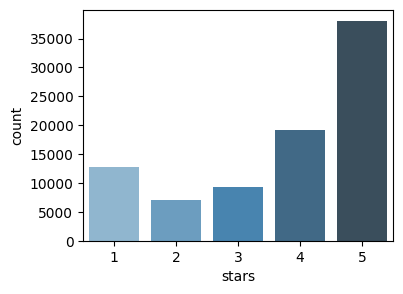

In [6]:
plt.figure(figsize=(4,3)) 
sns.countplot(data=review_data,x='stars', palette="Blues_d")  

Next, we're generating a distribution plot for the length of the text reviews 

Text(0.5, 1.0, 'Text Length Distribution')

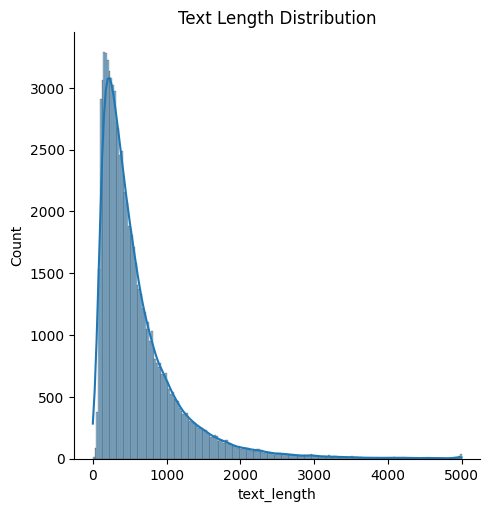

In [7]:
sns.displot(data=review_data,x='text_length',kde=True)  
plt.title('Text Length Distribution') 

### Data cleaning

We start by removing the stopwords from the text column

In [8]:
stop_words = set(stopwords.words("english")) 
def stopwords_removal(text) :
    return " ".join([word for word in text.lower().split() if word not in stop_words])

In [9]:
# Testing stopwords_removal function 
sentence = "This is a sentence with stopwords that need to be removed" 
stopwords_removal(sentence) 

'sentence stopwords need removed'

In [10]:
# making a copy of the dataframe 
copy_review = review_data.copy() 
copy_review['text'] = review_data['text'].apply(stopwords_removal) # Applying the stopwords_removal function
copy_review.head() 

,index,review_id,stars,text,year,text_length
0,491263,K1I5yuJICQpInOy-wCCo9A,5,staff friendly really like dr. hap. dental hyg...,2017,449
1,6662859,NOwHErM1-u4d8Z6vSS7FwA,1,usually great experience left extremely disapp...,2017,403
2,7361472,JjvOoHUs-OrPEnuUUanDsw,5,update: contacted shortly review email. tcg ab...,2016,1551
3,5119559,XaiIBzU7e2GUqrHflo9Ngw,5,"francesca truly accommodating kind, gave optio...",2020,346
4,7777005,wWPwXqz7yGiVgUTlXCxe9g,1,"send anyone care place! dear friend stroke, se...",2013,1280


In [11]:
copy_review['stars'].unique() 

array([5, 1, 4, 3, 2], dtype=int64)

In this step we're going to generate insights for both good and bad reviews based on the number of stars given by the user. <br> 
<ul>
<li>5 and 4 stars : Good review</li>
<li>3 stars : Neutral</li>
<li>1 and 2 stars : Bad review</li>
</ul>
We are going to add 'review' column who has 3 values Good,Neutral and Bad

In [12]:
def review_func(stars):
    if stars >= 4:
        return 'good'
    elif stars == 3:
        return 'neutral'
    else:
        return 'bad'


In [13]:
copy_review['review'] = copy_review['stars'].apply(review_func) 
copy_review.head() 

,index,review_id,stars,text,year,text_length,review
0,491263,K1I5yuJICQpInOy-wCCo9A,5,staff friendly really like dr. hap. dental hyg...,2017,449,good
1,6662859,NOwHErM1-u4d8Z6vSS7FwA,1,usually great experience left extremely disapp...,2017,403,bad
2,7361472,JjvOoHUs-OrPEnuUUanDsw,5,update: contacted shortly review email. tcg ab...,2016,1551,good
3,5119559,XaiIBzU7e2GUqrHflo9Ngw,5,"francesca truly accommodating kind, gave optio...",2020,346,good
4,7777005,wWPwXqz7yGiVgUTlXCxe9g,1,"send anyone care place! dear friend stroke, se...",2013,1280,bad


<Axes: xlabel='review', ylabel='count'>

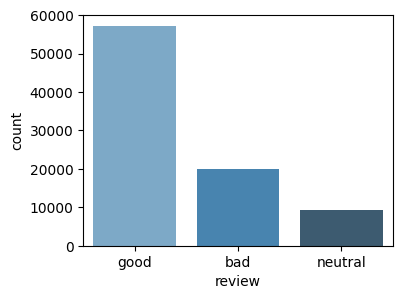

In [14]:
plt.figure(figsize=(4,3)) 
sns.countplot(data=copy_review,x='review', palette="Blues_d")  

In [15]:
def most_frequent_words(df,column_name) : 
    # Concatenate all reviews in the dataframe into a single string
    text = " ".join(review for review in df[column_name]) 

    words = word_tokenize(text) 
    word_frequency = Counter(words)     
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=stop_words,
                          min_font_size=10).generate_from_frequencies(word_frequency)

    
    # Display the word cloud
    plt.figure(figsize=(5, 5), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    

In [16]:
good_reviews = copy_review[copy_review['review']=='good'] 
bad_reviews = copy_review[copy_review['review']=='bad']  

In [17]:
good_reviews.head() 

,index,review_id,stars,text,year,text_length,review
0,491263,K1I5yuJICQpInOy-wCCo9A,5,staff friendly really like dr. hap. dental hyg...,2017,449,good
2,7361472,JjvOoHUs-OrPEnuUUanDsw,5,update: contacted shortly review email. tcg ab...,2016,1551,good
3,5119559,XaiIBzU7e2GUqrHflo9Ngw,5,"francesca truly accommodating kind, gave optio...",2020,346,good
6,8355097,npoWcuF9jgMBsDCTGSLvhw,5,awesome food great service. blood orange marga...,2018,193,good
8,3322213,ZeIRnk45yUOedrZgTi0UdA,4,decent thai food. got token thai dishes pad th...,2020,214,good


In [18]:
bad_reviews.head() 

,index,review_id,stars,text,year,text_length,review
1,6662859,NOwHErM1-u4d8Z6vSS7FwA,1,usually great experience left extremely disapp...,2017,403,bad
4,7777005,wWPwXqz7yGiVgUTlXCxe9g,1,"send anyone care place! dear friend stroke, se...",2013,1280,bad
5,7633404,fs8Vul2nzUnhPGM-JJ1-5w,1,delivery twice left side order drink! even goi...,2020,237,bad
7,5264638,1KA3rVnhxTIRI_Nzs9gJQg,1,go alone female... owner hit you.. way makes l...,2011,485,bad
11,5700491,GVrDq8yOKuf2Msq0jOynWg,1,"first time simoniz, definitely last. here's ha...",2017,1956,bad


### Modeling

In this part we're going to classify our reviews into a positif or negatif based on the starts and text columns. <br>
We'll consider only 5 and 1 stars. <br>
* 5 stars = good review
* 1 start = bad review  

In [19]:
selected_data = copy_review[['review','text']] 
#selected_data = new_data[(new_data['stars']==5) | (new_data['stars'] == 1)] 
selected_data.head() 

,review,text
0,good,staff friendly really like dr. hap. dental hyg...
1,bad,usually great experience left extremely disapp...
2,good,update: contacted shortly review email. tcg ab...
3,good,"francesca truly accommodating kind, gave optio..."
4,bad,"send anyone care place! dear friend stroke, se..."


Next we will devide our dataset into X and Y 

In [20]:
X = selected_data['text'] 
y = selected_data['review']  

Now we're going to use CountVectorizer function to vectorize the reviews 

In [21]:
count_vec = CountVectorizer().fit(X) 
X = count_vec.transform(X) 

In [22]:
print('The shape of X:',X.shape) 

The shape of X: (86352, 74982)


In [23]:
print('The shape of y',y.shape) 

The shape of y (86352,)


Now we're goind to devide our data into training and testing set

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2) 

#### Multinominal naive bayes model 

In [25]:
mnb = MultinomialNB() 
mnb.fit(X_train,y_train) 
y_pred = mnb.predict(X_test) 

In [26]:
print('- Confusion matrix of Multinominal naive bayes:\n',confusion_matrix(y_test,y_pred))
print('- Accuracy score:',accuracy_score(y_test,y_pred)) 
print('- Classification report:\n',classification_report(y_test,y_pred))  

- Confusion matrix of Multinominal naive bayes:
 [[ 2910   412   637]
 [  730 10229   470]
 [  366   892   625]]
- Accuracy score: 0.7969428521799549
- Classification report:
               precision    recall  f1-score   support

         bad       0.73      0.74      0.73      3959
        good       0.89      0.90      0.89     11429
     neutral       0.36      0.33      0.35      1883

    accuracy                           0.80     17271
   macro avg       0.66      0.65      0.66     17271
weighted avg       0.79      0.80      0.79     17271

